# About

## Author

    Thiago Luis Rodrigues Pinho @AILAB 

## Start Date

    30/04/2020

## Objectives

    Use an LDA components analysis for text documents and then evaluate their
    similarities using Jensen-Shannon Distance

## Summary

    1. Loading data
    2. Treating Data
    3. Generating LDA Component Analysis
        3.1 Finding Optimal Number of Components
        3.2 Generating Topics
    4. Similarity Jensen-Shannon
        4.1 Creating Topics Similarities Pairs
        4.2 Generating Heatmap for Text Similarities
    5. Bibliography




# [ALEI] IAgrupador LDA with Jensen-Shannon distance

In [3]:
from time import time

import gensim
from gensim import corpora, models
from fastparquet import write
from scipy.spatial import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set()

## 1. Loading data

In [4]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"

filename = "data_preprocessed"

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        2036 non-null   object
 1   process_id  2036 non-null   object
dtypes: object(2)
memory usage: 31.9+ KB
None
CPU times: user 2.71 s, sys: 148 ms, total: 2.86 s
Wall time: 3.4 s


## 2. Treating Data

In [5]:
num_samples = 100
sample_df = ailab_df.sample(n=num_samples)
sample_df = sample_df.drop_duplicates(subset='process_id')
sample_df['tokenized_docs'] = [ document_text.split() for document_text in sample_df['text'].to_list()]
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 699 to 1990
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            92 non-null     object
 1   process_id      92 non-null     object
 2   tokenized_docs  92 non-null     object
dtypes: object(3)
memory usage: 2.9+ KB
None


## 3. Generating LDA Component Analysis

### 3.1 Finding Optimal Number of Components

In [178]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2):
    """
    Creates a list of models with different number of topics and returns theirs topics average
    coherence_values. The greater the better.

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    
    for num_topics in range(start, limit+1):
        # Make a index to word dictionary.
        temp = dictionary[0]  # This is only to "load" the dictionary.
        id2word = dictionary.id2token

        model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                               alpha='auto', eta='auto', \
                               iterations=iterations, num_topics=num_topics, \
                               passes=passes, eval_every=eval_every, random_state=20)

        top_topics = model.top_topics(corpus)
        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        coherence_values.append(sum([t[1] for t in top_topics]) / num_topics)
        model_list.append(model)
    
    return model_list, coherence_values

In [81]:
tokenized_docs = sample_df['tokenized_docs'].to_list()
# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(tokenized_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Creating a corpus using their relative frequencies
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

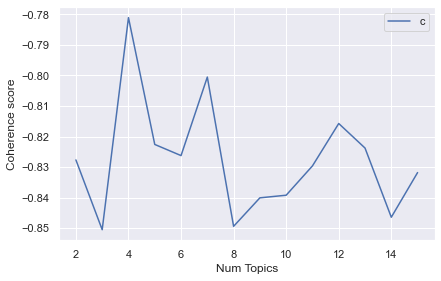

In [179]:
# Can take a long time to run.
MAXIMUM_NUMBER_COMPONENTS=15
MINIMUM_NUMBER_COMPONENTS=2
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=doc_term_matrix,
    texts=tokenized_docs,
    start=MINIMUM_NUMBER_COMPONENTS,
    limit=MAXIMUM_NUMBER_COMPONENTS)

# Show graph
x = range(MINIMUM_NUMBER_COMPONENTS, MAXIMUM_NUMBER_COMPONENTS+1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### 3.2 Generating Topics

In [180]:
best_model_index = coherence_values.index(max(coherence_values))
NUM_TOPICS = coherence_values.index(max(coherence_values)) + MINIMUM_NUMBER_COMPONENTS
best_model = model_list[best_model_index]
for idx, topic in best_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.023*"aposentadoria" + 0.018*"beneficio" + 0.016*"previdenciario" + 0.015*"inss" + 0.014*"servico" + 0.013*"email" + 0.013*"procuradoria" + 0.013*"conversao" + 0.012*"comum" + 0.012*"concessao"
Topic: 1 Word: 0.023*"contribuicao" + 0.015*"calculo" + 0.011*"valores" + 0.011*"contribuicoes" + 0.010*"previdenciaria" + 0.010*"documento" + 0.010*"titulo" + 0.009*"tributario" + 0.009*"prazo" + 0.008*"autora"
Topic: 2 Word: 0.035*"fazenda" + 0.033*"juros" + 0.025*"imposto" + 0.023*"correcao" + 0.022*"monetaria" + 0.021*"regional" + 0.020*"renda" + 0.015*"procuradoria" + 0.014*"agravo" + 0.014*"incidencia"
Topic: 3 Word: 0.013*"publica" + 0.011*"servidores" + 0.011*"recorrente" + 0.010*"fone" + 0.010*"repercussao" + 0.008*"servidor" + 0.007*"juridico" + 0.007*"centro" + 0.007*"catarina" + 0.007*"procuradoria"


In [181]:
corpus_tfidf = tfidf[doc_term_matrix]
probabilities = best_model[corpus_tfidf]
same_shape_probabilities = []
for topics_probability_list in probabilities:
    topics_probability_dict = dict()
    for index, score in topics_probability_list:
        topics_probability_dict[index] = score
    if len(topics_probability_dict) < NUM_TOPICS:
        for i in range(NUM_TOPICS):
            if i not in topics_probability_dict:
                topics_probability_dict[i] = 0.0
    same_shape_probabilities.append([topics_probability_dict[key] for key in sorted(topics_probability_dict.keys())])
sample_df['topics_similarity'] = same_shape_probabilities
sample_df

,text,process_id,tokenized_docs,topics_similarity
699,evento data pagina separacao gerada automatica...,699579,"[evento, data, pagina, separacao, gerada, auto...","[0.02130883, 0.900755, 0.022222776, 0.055713385]"
1671,horas extras carater remuneratorio incidencia ...,715364,"[horas, extras, carater, remuneratorio, incide...","[0.0, 0.9809364, 0.0, 0.010710459]"
113,documento recebido eletronicamente origem judi...,1077163,"[documento, recebido, eletronicamente, origem,...","[0.0, 0.017275872, 0.0, 0.96611834]"
1145,advocaciageral uniao procuradoriageral federal...,674326,"[advocaciageral, uniao, procuradoriageral, fed...","[0.97203827, 0.010202651, 0.0, 0.012759758]"
1039,advocaciageral uniao procuradoriageral federal...,1056216,"[advocaciageral, uniao, procuradoriageral, fed...","[0.969406, 0.01123488, 0.0, 0.013845141]"
...,...,...,...,...
371,faiz gudici termo remessa externa remessa auto...,1071834,"[faiz, gudici, termo, remessa, externa, remess...","[0.015192946, 0.92920756, 0.01584458, 0.039754..."
962,lage alencar advogados pedido exposto insurgen...,1071958,"[lage, alencar, advogados, pedido, exposto, in...","[0.0, 0.0, 0.0, 0.98080766]"
1690,assentado corte especial tribunal arguicao inc...,1082108,"[assentado, corte, especial, tribunal, arguica...","[0.0, 0.3618235, 0.61753935, 0.0149345435]"
837,exmo desembargador presidente tribunal regiona...,950508,"[exmo, desembargador, presidente, tribunal, re...","[0.7264422, 0.25727096, 0.0, 0.011651802]"


## 4. Similarity Jensen-Shannon

### 4.1 Creating Topics Similarities Pairs
It's necessary to prepare data so each input is a pair os texts and if they are close

In [182]:
%time
text_pairs = []
comparing_same_text = True
for question_1_index, question_1_row in sample_df.iterrows():
    question_1_text = question_1_row['topics_similarity']
    question_1_id = question_1_row['process_id']
    for question_2_index, question_2_row in sample_df.iterrows():
        if not comparing_same_text and question_1_index == question_2_index:
            continue
        question_2_text = question_2_row['topics_similarity']
        question_2_id = question_2_row['process_id']
        text_pairs.append([question_1_id, question_1_text, question_2_id, question_2_text])

pair_text_df = pd.DataFrame(text_pairs, columns=['question1_id', 'question1', 'question2_id', 'question2'])
print(pair_text_df.info())

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8464 entries, 0 to 8463
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question1_id  8464 non-null   object
 1   question1     8464 non-null   object
 2   question2_id  8464 non-null   object
 3   question2     8464 non-null   object
dtypes: object(4)
memory usage: 264.6+ KB
None


#### Storing partial results

In [103]:
pair_text_filename = "text_pairs" + str(num_samples)
pair_text_parquet_filename = RELATIVE_FOLDER_PATH + pair_text_filename + ".parquet.gzip"

In [10]:
write(pair_text_parquet_filename, pair_text_df, compression='gzip')

#### Loading partial results

In [11]:
pair_text_df = pd.read_parquet(pair_text_parquet_filename)
print(pair_text_df.head())

  question1_id                                          question1  \
0       789324  documento digitalizado juntado processo usuari...   
1       789324  documento digitalizado juntado processo usuari...   
2       789324  documento digitalizado juntado processo usuari...   
3       789324  documento digitalizado juntado processo usuari...   
4       789324  documento digitalizado juntado processo usuari...   

  question2_id                                          question2  
0       789324  documento digitalizado juntado processo usuari...  
1       824250  estj poper jupiciario tribunal regional federa...  
2       979045  judiciario supremo tribunal federal recibo pet...  
3      1013618  creristton prado advocacia analogia utilizacao...  
4      1131116  discussao inclusao creditos decorrentes contri...  


### 4.2 Generating Heatmap for Text Similarities

In [183]:
unique_ids_list = pair_text_df['question1_id'].unique().tolist()

unique_ids_list.sort()
print(unique_ids_list)

['1000220', '1021585', '1022060', '1022830', '1029623', '1030718', '1030967', '1033516', '1044318', '1050612', '1051284', '1052273', '1052373', '1054421', '1056216', '1059014', '1062003', '1062722', '1064395', '1071834', '1071958', '1074289', '1077163', '1082108', '1086545', '1093202', '1093208', '1094985', '1097191', '1097429', '1109164', '1112546', '1113113', '1125488', '1131525', '1139804', '1145986', '1146355', '1149358', '1153380', '1157652', '1159863', '1165322', '587982', '651124', '657093', '661259', '662557', '674326', '676044', '676409', '676624', '679912', '687333', '699579', '714478', '715364', '717806', '723413', '727043', '732995', '737385', '740562', '740565', '740603', '748082', '771172', '787132', '787966', '791715', '794229', '797654', '799897', '805214', '806989', '811207', '811311', '811921', '812669', '812706', '816998', '822647', '825063', '827996', '828090', '854099', '916369', '928441', '948947', '950508', '967900', '998348']


In [184]:
dimension = len(unique_ids_list)
distances_mapped = dict()
for choosen_id in unique_ids_list:
    choosen_question_mask = pair_text_df['question1_id'].values == choosen_id
    compared_df = pair_text_df[choosen_question_mask]
    
    compared_df.sort_values(by=['question2_id'], inplace=True)
    
    compared_ids_list = compared_df['question2_id'].to_list()
    if compared_ids_list != unique_ids_list:
        break
        print("An error ocurred")
    
    predictions_list = []
    for pair_text_index, pair_text_row in compared_df.iterrows():
        row_distance = 1 - distance.jensenshannon(pair_text_row['question1'], pair_text_row['question2'])
        predictions_list.append(row_distance)
    distances_mapped[choosen_id] = predictions_list

/home/dev/PythonEnviroments/ailab-researching/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Reordering rows and columns to improve visualisation

In [185]:
mapped_distances_df = pd.DataFrame.from_dict(distances_mapped, orient='index',
                       columns=unique_ids_list)
first_question_id = unique_ids_list[0]
mapped_distances_df.sort_values(by=[first_question_id], ascending=False, inplace=True)
mapped_distances_df = mapped_distances_df[mapped_distances_df.index]
mapped_distances_df.head()

,1000220,679912,1097429,791715,827996,822647,1159863,1052373,806989,799897,...,717806,676044,740562,740603,1056216,674326,1052273,1157652,1139804,732995
1000220,1.000000,0.995019,0.971940,0.963771,0.931676,0.909591,0.902874,0.888802,0.845557,0.840039,...,0.217931,0.212263,0.209193,0.206828,0.203583,0.201072,0.200999,0.184689,0.184684,0.184131
679912,0.995019,1.000000,0.976919,0.968749,0.926708,0.914553,0.902596,0.883856,0.840646,0.835134,...,0.217967,0.212294,0.209222,0.206854,0.203606,0.201094,0.201020,0.184748,0.184743,0.184188
1097429,0.971940,0.976919,1.000000,0.991826,0.903713,0.937572,0.898136,0.860976,0.817938,0.812452,...,0.218103,0.212411,0.209328,0.206954,0.203695,0.201179,0.201101,0.185011,0.185006,0.184440
791715,0.963771,0.968749,0.991826,1.000000,0.895581,0.945732,0.895394,0.852890,0.809918,0.804442,...,0.218139,0.212442,0.209356,0.206980,0.203719,0.201202,0.201123,0.185100,0.185095,0.184526
827996,0.931676,0.926708,0.903713,0.895581,1.000000,0.841765,0.883231,0.956934,0.913318,0.907738,...,0.217190,0.211626,0.208611,0.206286,0.203097,0.200618,0.200556,0.183789,0.183784,0.183267


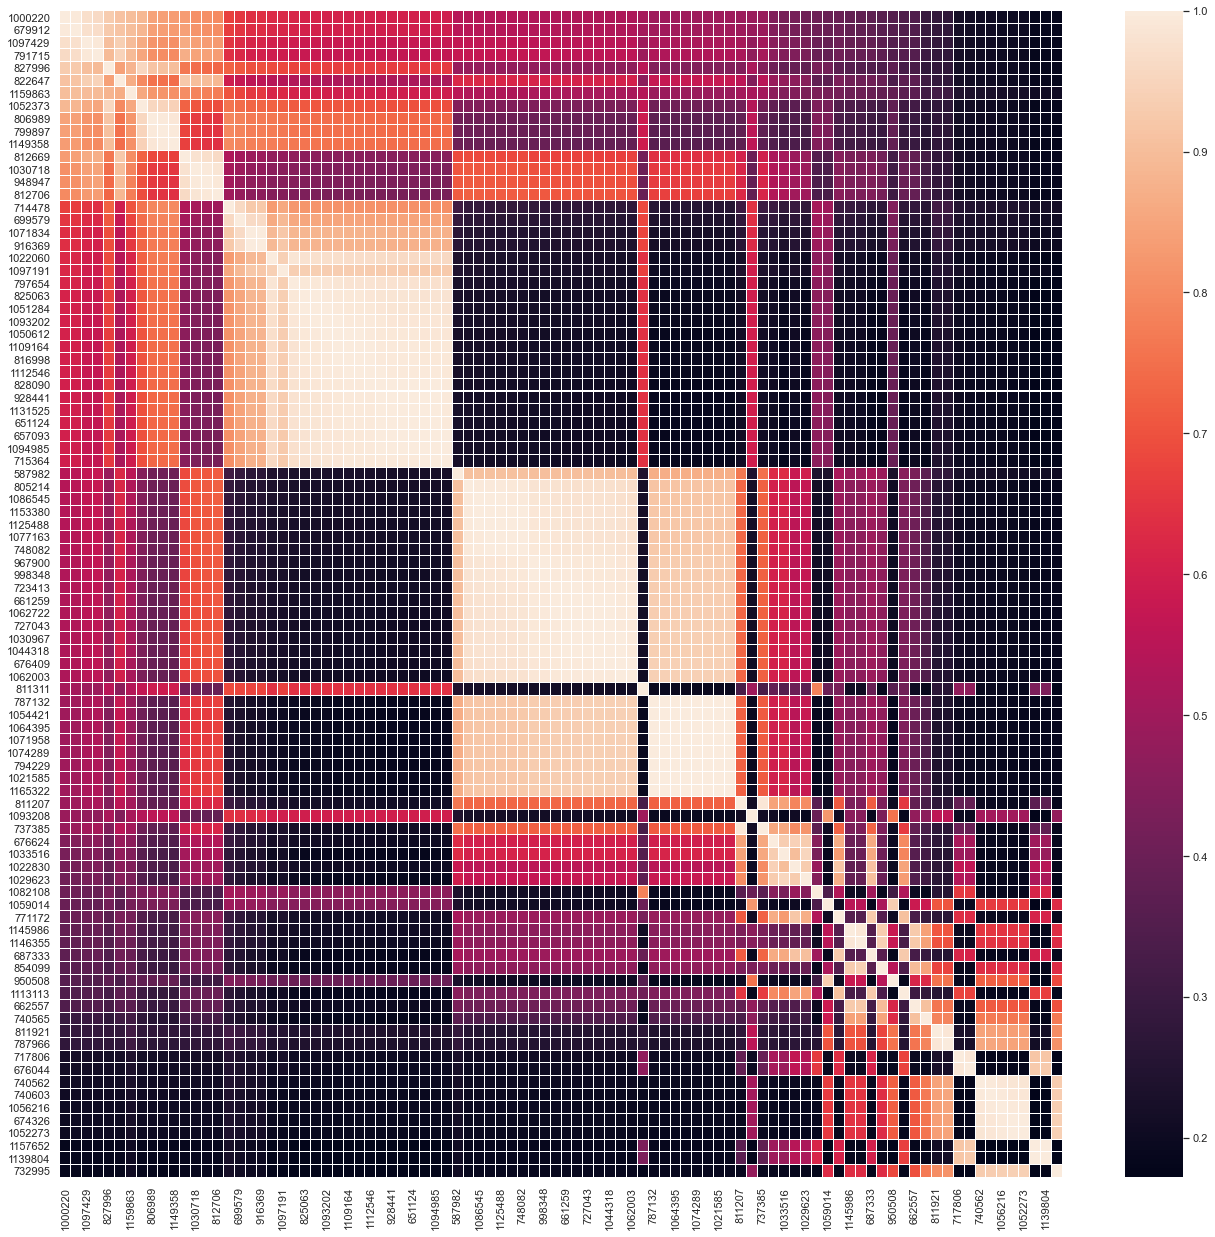

In [186]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(mapped_distances_df, linewidths=0.01)

## 5. Bibliography
Topic Modeling and Latent Dirichlet Allocation (LDA) in Python. Susan Li.
[Available at](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24). Last visited: 30/04/2020

Topic Modeling with Gensim (Python). Selva Prabhakaran. [Available at](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/). Last visited: 04/05/2020

Pre-processing and training LDA. Mohit Rathore. [Available at](https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html). Last visited: 04/05/2020
